This notebook contains various modifications to the original solve_bvp problem to signifcantly improve its performance. It also contains an attempt at coding the shooting method.

In [6]:
import numpy as np
import sympy as sp
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import root
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap, jvp, jacfwd, jvp

In [2]:
# Initialize hyperparamters
tf = 5.0    # Final time
lam = 3     # lambda
n = 2       # Dimension of the problem (code below for initialization will not work if you choose a different dimension)
d = 5       # Number of dogs
s = 2       # Number of sheep
alpha, beta = 1, .02
epsilon = 1e-1

def x_mod(x):
    # Add epsilon to x
    return jnp.concatenate((x, np.full(x.shape[:-1] + (1,), np.sqrt(epsilon))), axis=-1)

def a_fun(x):
    # Calculate acceleration term
    return x / jnp.linalg.norm(x_mod(x), axis=-1, keepdims=True)**lam

def a_der(x):
    # Calculate derivative of accceleration term
    x_norm = jnp.expand_dims(jnp.linalg.norm(x_mod(x), axis=-1, keepdims=True), -1)
    return x_norm**(-lam) * (jnp.eye(n) - lam * jnp.einsum("...i, ...j -> ...ij", x, x) / x_norm**2)


def ode_f(x):
    # Calculate derivative of state and costate together
    x = x.reshape(-1, n)

    d_state = x[:d]
    d_vel = x[d:2*d]
    s_state = x[2*d:2*d+s]
    s_vel = x[2*d+s:2*d+2*s]
    d_costate = x[2*d+2*s:3*d+2*s]
    d_covel = x[3*d+2*s:4*d+2*s]
    s_costate = x[4*d+2*s:4*d+3*s]
    s_covel = x[4*d+3*s:]

    d_state_der = d_vel
    d_vel_der = .5 * d_covel
    s_state_der = s_vel
    s_vel_der = jnp.sum(a_fun(s_state - jnp.expand_dims(d_state, 1)), axis=0)

    product = jnp.einsum("...ij, ...j -> ...i", a_der(s_state - jnp.expand_dims(d_state, 1)), s_covel)
    d_costate_der = jnp.sum(product, axis=1) + 2*beta*(jnp.linalg.norm(d_state, axis=-1, keepdims=True)**2-1)*d_state
    d_covel_der = -d_costate
    s_costate_der = -jnp.sum(product, axis=0) + 2*alpha*s_state
    s_covel_der = -s_costate

    return jnp.vstack([d_state_der, d_vel_der, s_state_der, s_vel_der, d_costate_der, d_covel_der, s_costate_der, s_covel_der]).flatten()



# Define various helper functions
def der_wrapper(t, x):
    return vmap(ode_f, in_axes=-1, out_axes=-1)(x)

def jac_fun(t, x):
    def my_jac(x):
        return jacfwd(ode_f)(x)
    return vmap(my_jac, in_axes=-1, out_axes=-1)(x)

def jac_bc(ya, yb):
    zeros = np.zeros((2*n*(d+s), 2*n*(d+s)))
    return np.block([[np.eye(2*n*(d+s)), zeros], [zeros, zeros]]), np.block([[zeros, zeros], [zeros, np.eye(2*n*(d+s))]])

def find_trajectory_bvp(initial_dogs, initial_sheep, y0, T):
    """Get trajectory from iniital state of dogs (initial_dogs) and sheep (initial_sheep), the number of initial mesh points T,
    and the initial solution guess y
    """
    x0 = np.concatenate([initial_dogs.flatten(), 0.1*np.random.randn(n*d), initial_sheep.flatten(), 0.1*np.random.randn(n*s)])
    t = np.linspace(0, tf, T)

    def bc(ya, yb):
        return np.concatenate([ya[:2*n*(d+s)] - x0, yb[2*n*(d+s):]])
    
    res_bvp = None
    y = y0

    # OLD CODE FOR UPDATING COSTATE WITHOUT UPDATING STATE
    # for _ in range(5):
    #     y[:2*n*(d+s)] = y0[:2*n*(d+s)]
    #     y[2*n*(d+s)+n*d:2*n*(d+s)+2*n*d] = y0[2*n*(d+s)+n*d:2*n*(d+s)+2*n*d]
    #     res_bvp = solve_bvp(der_wrapper, bc, t, y, fun_jac=jac_fun, bc_jac=jac_bc, max_nodes=500, verbose=2)
    #     y = res_bvp.sol(t)

    for _ in range(10):
        res_bvp = solve_bvp(der_wrapper, bc, t, y, fun_jac=jac_fun, bc_jac=jac_bc, max_nodes=2000, verbose=2, tol=5e-6)
        y = res_bvp.sol(t)
        if res_bvp.success:
            break

    return res_bvp

In [3]:
def new_to_old(x):
    """Converts notation above for state and costate to notation elsewhere in this Github"""
    y = x.reshape(-1, 2)
    old_y = np.block([[y[:d], y[d:2*d]],
                      [y[2*d:2*d+s], y[2*d+s:2*d+2*s]],
                      [y[2*d+2*s:3*d+2*s], y[3*d+2*s:4*d+2*s]],
                      [y[4*d+2*s:4*d+3*s], y[4*d+3*s:]]])
    return old_y.flatten()

def old_to_new(x):
    """Converts notation notation elsewhere in this Github to notation above for state and costate"""
    y =  y = x.reshape(-1, 4)
    new_y = np.concatenate([y[:d, :2], y[:d, 2:], y[d:d+s, :2], y[d:d+s, 2:], y[d+s:2*d+s, :2], y[d+s:2*d+s, 2:], y[2*d+s:, :2], y[2*d+s:, 2:]], axis=-2)
    return new_y.flatten()

# Vectorized implementations of the above conversion
def new_to_old_vectorized(x):
    return np.apply_along_axis(new_to_old, axis=0, arr=x)
def old_to_new_vectorized(x):
    return np.apply_along_axis(old_to_new, axis=0, arr=x)

# Test conversion works
x = np.random.randn(4*n*(d+s))
print(np.allclose(x, new_to_old(old_to_new(x))))
print(np.allclose(x, old_to_new(new_to_old(x))))

True
True


In [4]:
def make_video(t_solution, y_solution, D=2, S=1, name="dogs_sheep_animation"):
    """Function to plot solution. Note that the notation for this function is the notation used elsewhere in this Github,
    so the conversion function above must first be applied
    """
    ts = t_solution
    num_agents = D + S
    
    # Split y_solution into positions and velocities
    positions = y_solution[:4 * num_agents]
    
    # Extract x and y coordinates
    x_coords = positions[::4]  # Every 4th element starting at index 0
    y_coords = positions[1::4]  # Every 4th element starting at index 1
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(min([np.min(x) for x in x_coords]) - 1, max([np.max(x) for x in x_coords]) + 1)
    ax.set_ylim(min([np.min(y) for y in y_coords]) - 1, max([np.max(y) for y in y_coords]) + 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Animation of State Evolution')
    
    # Assign colors: Green for dogs, Red for sheep
    colors = ['g'] * D + ['r'] * S
    markers = ['o'] * num_agents
    
    # Initialize points and trails
    points = [ax.plot([], [], color + markers[i], markersize=8)[0] for i, color in enumerate(colors)]
    trails = [ax.plot([], [], color + '-', alpha=0.5)[0] for color in colors]
    
    # Lists to store trail paths
    trail_x, trail_y = [[] for _ in range(num_agents)], [[] for _ in range(num_agents)]
    
    # Add a marker at the origin and legend
    ax.plot(0, 0, 'kX', markersize=5)
    ax.grid(True)
    ax.legend([points[i] for i in range(num_agents)], [f'Agent {i+1}' for i in range(num_agents)])
    
    # Update function for animation
    def update(frame):
        for i in range(num_agents):
            points[i].set_data([x_coords[i][frame]], [y_coords[i][frame]])
            trail_x[i].append(x_coords[i][frame])
            trail_y[i].append(y_coords[i][frame])
            trails[i].set_data(trail_x[i], trail_y[i])
        return points + trails
    
    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(ts), interval=50, blit=True)
    ani.save(name + '.mp4', writer='ffmpeg', fps=30)
    
    print(f"Video saved at {name}.mp4")
    plt.show()

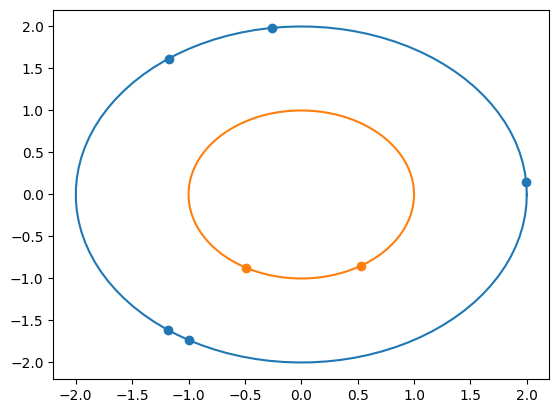

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.84e+00       1.32e-01          200            398      
       2          1.26e+01       1.25e-15          598           1194      
       3          3.29e+01       2.40e-15         1792          (3582)     
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 3.29e+01 
Maximum boundary residual: 2.40e-15
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.34e+01       1.26e-15          200            398      
       2          7.56e+00       1.07e-15          598           1193      
       3          4.31e+00       6.88e-16         1791          (3570)     
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 4.31e+00 
Maximum boundary residual: 6.88e-16
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.73e+00       1.53e-16          200            394     

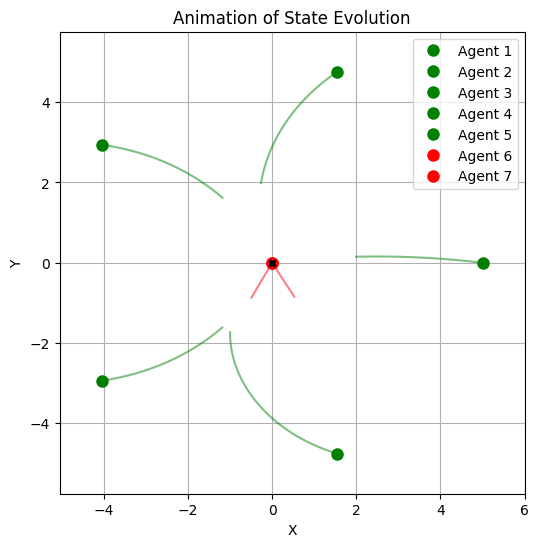

Video saved at my_solution.mp4


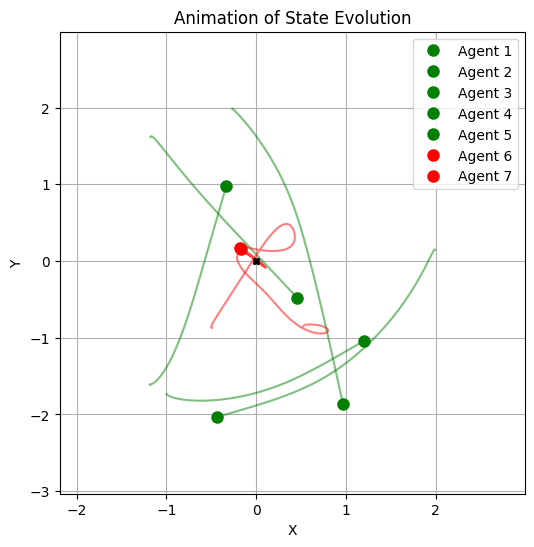

In [5]:
def make_random_solution(initial_trajectory_name="my_initial_guess", final_trajector_name="my_solution"):
    """Randomly initializes dog and sheep positions and then calculations optimal solution. An animation for the initial trajectory guess and the final computed solution
    are saved using the names above. Note that this code sometimes does not converge.
    """
    
    # Intialize dogs and sheep. Their initial positions are plotted.
    R = 2   # Initial radius of the dogs
    initial_dogs = np.random.randn(d, n)
    initial_dogs = R * initial_dogs / np.linalg.norm(initial_dogs, axis=-1, keepdims=True)
    plt.scatter(initial_dogs[:, 0], initial_dogs[:, 1])
    t_vals = np.linspace(0, 2*np.pi, 100)
    plt.plot(R*np.cos(t_vals), R*np.sin(t_vals))

    initial_sheep = np.random.randn(s, n)
    initial_sheep = initial_sheep / np.linalg.norm(initial_sheep, axis=-1, keepdims=True)
    plt.scatter(initial_sheep[:, 0], initial_sheep[:, 1])
    plt.plot(np.cos(t_vals), np.sin(t_vals))
    plt.show()


    # Create initial mesh and map roots of unity to each of the dogs
    T = 200     # Initial number of mesh nodes
    t = np.linspace(0, tf, T)
    thetas = np.angle(initial_dogs[:, 0] + 1j*initial_dogs[:, 1])
    i0 = np.argmin(np.abs(thetas))
    theta_args = np.argsort(thetas)
    j0 = np.where(theta_args==i0)[0][0]


    # Creates trajectory for a single dog
    def get_dog_trajectory(r0, rf, theta0, thetaf, T, tf):
        t = np.linspace(0, tf, T)
        def trajectory(t):
            return ((1 - t/tf)*r0 + (t/tf)*rf) * jnp.exp(1j*((1 - t/tf)*theta0 + (t/tf)*thetaf))
        def vgrad(t):
            return vmap(lambda y: (trajectory(y),) + jvp(lambda x: jvp(trajectory, (x,), (1.0,))[1], (y,), (1.0,)), in_axes=0, out_axes=0)(t)
        
        return vgrad(t)


    # Get initial trajectory for dogs
    guess_radius = 5        # Radius at which the initial trajectory goes out to
    dog_trajectory = np.zeros((d, n, T))
    dog_velocity = np.zeros((d, n, T))
    dog_covelocity = np.zeros((d, n, T))

    for j in range(j0, d):
        i = theta_args[j]
        theta = thetas[i]
        thetaf = 2*np.pi *(j-j0)/d
        theta0 = theta if np.abs(theta - thetaf) < np.abs(2*np.pi + theta - thetaf) else 2*np.pi + theta
        r0 = np.linalg.norm(initial_dogs[i])
        rf = guess_radius
        traj, velo, acc = get_dog_trajectory(r0, rf, theta0, thetaf, T, tf)
        dog_trajectory[i] = np.stack([traj.real, traj.imag], axis=0)
        dog_velocity[i] = np.stack([velo.real, velo.imag], axis=0)
        dog_covelocity[i] = np.stack([acc.real, acc.imag], axis=0) / 2
    for j in range(j0):
        i = theta_args[j]
        theta = thetas[i]
        thetaf = 2*np.pi *(j+d-j0)/d
        theta0 = theta if np.abs(theta - thetaf) < np.abs(2*np.pi + theta - thetaf) else 2*np.pi + theta
        r0 = np.linalg.norm(initial_dogs[i])
        rf = guess_radius
        traj, velo, acc = get_dog_trajectory(r0, rf, theta0, thetaf, T, tf)
        dog_trajectory[i] = np.stack([traj.real, traj.imag], axis=0)
        dog_velocity[i] = np.stack([velo.real, velo.imag], axis=0)
        dog_covelocity[i] = np.stack([acc.real, acc.imag], axis=0) * 2

    # Intialize sheep trajectory
    sheep_trajectory = (1 - t/tf) * initial_sheep[:, :, None]
    sheep_velocity = -initial_sheep[:, :, None] / tf + 0*t

    # Create initial guess
    y_guess = np.concatenate([dog_trajectory.reshape(-1, T), dog_velocity.reshape(-1, T), sheep_trajectory.reshape(-1, T), sheep_velocity.reshape(-1, T), 0.1 * np.random.randn(n*d, T), dog_covelocity.reshape(-1, T), 0.1*np.random.randn(2*n*s, T)], axis=0)

    # Get solution
    sol = find_trajectory_bvp(initial_dogs, initial_sheep, y_guess, T)


    # Make animations of the solution
    make_video(t, new_to_old_vectorized(y_guess), D=d, S=s, name=initial_trajectory_name)
    make_video(t, new_to_old_vectorized(sol.sol(t)), D=d, S=s, name=final_trajector_name)

make_random_solution()

In [7]:
# ATTEMPT AT SHOOTING METHOD. PROBABLY WILL NOT WORK
def vmap_jmp(f, W, M):
    _jvp = lambda s: jvp(f, (W,), (s,))[1]
    return vmap(_jvp)(M.T).T


def ode_shooting(t, x):
    # Split vector
    x_val = x[:4*n*(d+s)]
    M = x[4*n*(d+s):].reshape(4*n*(d+s), 2*n*(d+s))

    # Return derivative
    return jnp.concatenate([ode_f(x_val), vmap_jmp(ode_f, x_val, M).flatten()])

M0 = np.vstack([np.zeros((2*n*(d+s), 2*n*(d+s))), np.eye(2*n*(d+s))]).flatten()



def trajectory_iter(x0, p0):
    y0 = np.concatenate([x0, p0, M0])
    return solve_ivp(ode_shooting, (0, tf), y0)


def find_trajectory(x0, p_guess):
    x0 = x0.flatten()
    def trajector_wrapper(p0):
        sol = trajectory_iter(x0, p0).y[:, -1]
        return sol[2*n*(s+d):4*n*(s+d)], sol[-4*n**2*(s+d)**2:].reshape(2*n*(s+d), 2*n*(s+d))
    
    return root(trajector_wrapper, p_guess.flatten(), jac=True)